<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3c_OSI_SAF_sea_ice_mapping_Ice_Type.ipynb" target="_blank"><< Mapping OSI SAF sea ice type</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=".1_3e_OSI_SAF_sea_ice_mapping_Ice_Emissivity.ipynb" target="_blank">Mapping OSI SAF sea ice emissivity >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_sea_ice_introductory%2F1_3d_OSI_SAF_sea_ice_mapping_ice_drift.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3d Mapping OSI SAF sea ice drift 
### Data used 

| Product Description | Product Navigator | OSI SAF website link | OSI SAF Identifier |
|:--------------------:|:-------------:|:-----------------:|:-----------------:|
| Global Low Resolution Sea Ice Drift | EO:EUM:DAT:MULT:GBL-LR-SIDR | <a href="https://osi-saf.eumetsat.int/products/osi-405-c" target="_blank">link</a> | OSI-405-c | 


### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Drift netcdf
* Map Sea Ice Drift using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Mapping sea ice concentration - Northern Hemisphere](#section1)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                               # a library that allows us access to basic operating system commands
import xarray as xr                     # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl                # a library for visualization
import matplotlib.patches as mpatches   # a part of the plotting library
import matplotlib.pyplot as plt         # a library that supports plotting
import matplotlib.cm as mpl_cm          # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs              # a mapping library that supports reprojection
import cartopy.feature as cfeature      # a part of the mapping library that provides features such as coastlines
import cmocean                          # colormaps for ocean products
import cmcrameri                        # scientific colormaps for data visualisation
import numpy as np                      # a library that supports array manipulation
import warnings                         # a library that controls python warnings
from netCDF4 import Dataset 
warnings.filterwarnings('ignore')

##
<div class="alert alert-info" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_ice_drift` create a plot figure of sea ice concentration product available in the directory **directory** with a specific output projection and a specific region of the globe if given.

In [2]:
def mapping_ice_drift(directory, file_edge, output_projection, cmap, ax=None, title="", region=None):
    """
    Function to map Sea Ice drift. 

     Args:
        directory (string)        : the directory where files are
        file_edge                 : file that contain edge data
        output_projection         : the output projection to plot map
        cmap                      : color palette
        ax                        : axes of the plot
        region (list)             : the region to zoom in. If not region is given, plot a global map
        title (string)            : title of the plot
    Returns:
        im                        : the plotting figure

    """
        
    # set data projection
    data_projection=ccrs.PlateCarree()
    
    if not ax: ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
    if region: ax.set_extent(region, crs=data_projection)
    ax.add_feature(cfeature.OCEAN, zorder=0) # Change color of ocean
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black')  # Change color of land
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
   
    ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label
    ax.coastlines()    # Add coastline
    # Add title
    plt.title(title, fontsize=18)

    for filename in os.listdir(directory):
        if filename.endswith(".nc"):
            print(filename)
            nc = Dataset(directory + '/' + filename)
            lat = nc.variables['lat'][:]   
            lon = nc.variables['lon'][:]
            dX = nc.variables['dX'][:]
            dY = nc.variables['dY'][:]
            status_flag = nc.variables['status_flag'][:]

            nc.close()
            
            # Mask data with status flag < 20 or data_status >0
            dX = np.ma.masked_where(status_flag<20, dX)
            dX = np.ma.array(dX[0,:,:])
            dY = np.ma.array(dY[0,:,:])
            
            # Plot drift with arrow
            x0_l = []
            y0_l = []
            ar = []
            pdx_l = []
            pdy_l = []
            for i in range(lon[~dX.mask].size):
                # Transform point from data projection to output projection
                x0, y0 = output_projection.transform_point(
                                    lon[~dX.mask][i],
                                    lat[~dX.mask][i],
                                    src_crs=data_projection)
                
                # Calcul the length of arrow            
                len_arrow = np.sqrt(dX[~dX.mask][i]**2 + dY[~dX.mask][i]**2)
                
                # Calculate the endpoints and therefore dx, dy
                # components of the drift arrows in the plot
                # coordinate system
                xorig, yorig = output_projection.transform_point(
                                    lon[~dX.mask][i],
                                    lat[~dX.mask][i],
                                    src_crs=data_projection)
                xarr = xorig + dX[~dX.mask][i]
                yarr = yorig + dY[~dY.mask][i]
                x1, y1 = output_projection.transform_point(xarr, yarr,
                                    src_crs=output_projection)
                    
                pdx = x1 - x0
                pdy = y1 - y0

                # Save all information for plotting
                x0_l.append(x0)
                y0_l.append(y0)
                ar.append(len_arrow)
                pdx_l.append(pdx)
                pdy_l.append(pdy)
            
            nc = xr.open_dataset(file_edge)
            xc = nc.variables['xc'][:]   
            yc = nc.variables['yc'][:]   
            # lat = nc.variables['lat'][:]   
            # lon = nc.variables['lon'][:]
            ice_edge = nc.variables['ice_edge'][:]
            status_flag  = nc.variables['status_flag'][:]
            nc.close()

            # Sea Ice Concentration data is provided in x y coordinates, bounds need to be defined for cartopy
            bounds=(xc.min()*1000,xc.max()*1000,yc.min()*1000,yc.max()*1000)

            # plotting sea ice edge
            im = ax.imshow(ice_edge[0,:,:], transform=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0), cmap=plt.cm.Greys_r, extent=bounds)
           
            # map ice drift with quiver
            im = ax.quiver(x0_l,y0_l, pdx_l, pdy_l, ar, cmap=cmap)
        
            return im

The function name `add_colorbar` create a colorbar of the image im.

In [3]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.05,0.1,0.75,0.02))
        ax = fig.add_axes([0.38,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.8,0.05,0.02,0.8))
        ax = fig.add_axes([0.7,.85,0.2,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    logo = plt.imread("../OSISAF_Name_Colour.png")
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('Ice drift [km]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mapping sea ice drift - Global Low Resolution Sea Ice Drift
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [4]:
directory = 'products/sea_ice_drift_lr/nh/'

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [5]:
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.oslo
cmap = mpl_cm.get_cmap('inferno')

Sea Ice Drift data has a specific projection. We can explore the netcdf file to find the characteristics.

In [6]:
for filename in os.listdir(directory):
    print(filename)
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)

ice_drift_nh_polstere-625_multi-oi_202307281200-202307301200.nc


In [7]:
nc

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 119, yc: 177)
Coordinates:
  * time                      (time) datetime64[ns] 2023-07-30T12:00:00
  * xc                        (xc) float64 -3.75e+03 -3.688e+03 ... 3.625e+03
  * yc                        (yc) float64 5.75e+03 5.688e+03 ... -5.25e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    dt0                       (time, yc, xc) timedelta64[ns] ...
    lon1                      (time, yc, xc) float32 ...
    lat1                      (time, yc, xc) float32 ...
    dt1                       (time, yc, xc) timedelta64[ns] ...
    dX                        (time, yc, xc) float32 ...
    dY                        (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) int8 ...
    uncert_dX_and_dY          (time, yc, xc) float32 ...
Attributes: (12/30)
    title:                   Daily Low Resolution Sea Ice Displacement from O...
    product_id:              OSI-405
    product_name:            osi_saf_lr_ice_drift
    product_status:          operational
    abstract:                Gridded ice displacement fields obtained from  s...
    topiccategory:           Oceans ClimatologyMeteorologyAtmosphere
    ...                      ...
    references:              Product User Manual for OSI-405-c, Lavergne, v1....
    history:                 2023-07-31 creation
    product_version:         2.0
    software_version:        5.1
    netcdf_version:          3.6.3
    Conventions:             CF-1.4

Setting geographical area.

In [8]:
lon_min = 0
lon_max = 180
lat_min = 65
lat_max = 90

Mapping figure based on retrieved netcdf file.

ice_drift_nh_polstere-625_multi-oi_202307281200-202307301200.nc


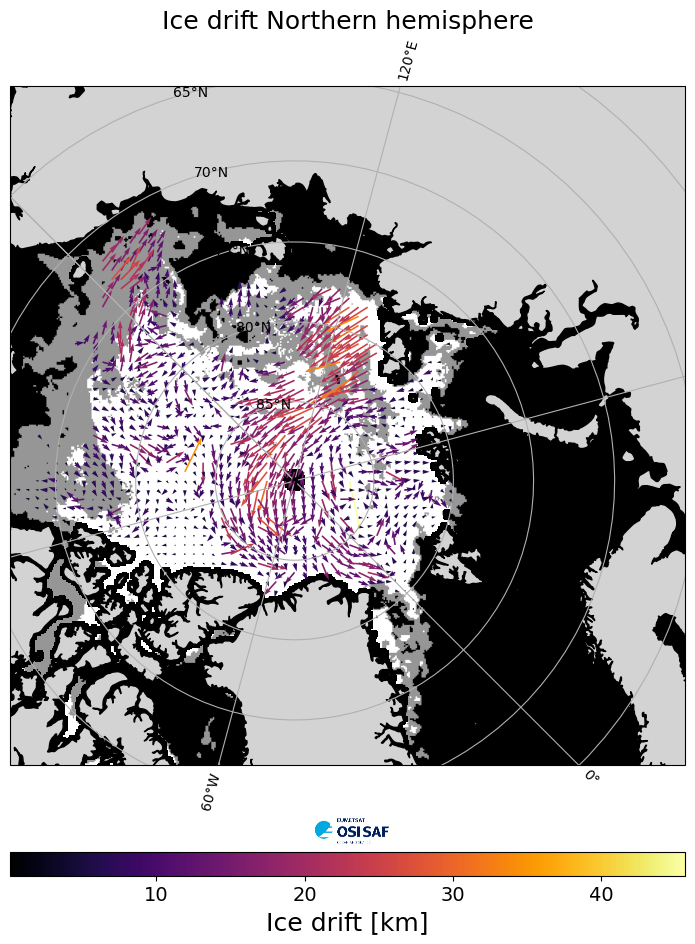

In [9]:
fig = plt.figure(figsize=(9,12))
# request output projection
output_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)

# map ice drift
im = mapping_ice_drift(directory, 
                       "products/sea_ice_edge/nh/ice_edge_nh_polstere-100_multi_202307231200.nc",
                       output_projection, 
                       cmap, 
                       title="Ice drift Northern hemisphere",
                       region=[lon_min,lon_max,lat_min, lat_max])

# Adding a colorbar       
add_colorbar(im, fig, orientation="horizontal", cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section1'></a>2. Mapping sea ice drift - Medium Resolution Sea Ice Drift
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [10]:
directory = 'products/sea_ice_drift_mr/nh'

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [11]:
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.oslo
cmap = mpl_cm.get_cmap('inferno')

Sea Ice Drift data has a specific projection. We can explore the netcdf file to find the characteristics.

In [12]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)

In [13]:
nc

<xarray.Dataset>
Dimensions:                   (xc: 379, yc: 559)
Coordinates:
  * xc                        (xc) float64 -3.78e+06 -3.76e+06 ... 3.78e+06
  * yc                        (yc) float64 5.58e+06 5.56e+06 ... -5.58e+06
Data variables:
    Polar_Stereographic_Grid  int32 ...
    data_status               (yc, xc) int32 ...
    correlation               (yc, xc) float32 ...
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
    lat1                      (yc, xc) float32 ...
    lon1                      (yc, xc) float32 ...
    dX                        (yc, xc) float32 ...
    dY                        (yc, xc) float32 ...
    Uncertainty               (yc, xc) float32 ...
Attributes: (12/36)
    title:                   OSI SAF - Medium Resolution Sea Ice Displacement
    abstract:                Gridded ice displacement fields obtained from  s...
    topiccategory:           Oceans Climatology Meteorology Atmosphere
    keywords:                Sea Ice Motion, Sea Ice, Oceanography, Meteorolo...
    gcmd_keywords:           Cryosphere > Sea Ice > Sea Ice Motion\nOcean > S...
    activity_type:           Space borne instrument
    ...                      ...
    valid_data_prefilter:    427
    valid_data:              52
    leap_days:               0.98541665
    references:              OSI SAF Medium Resolution Sea Ice Drift Product ...
    comment:                 This gridded product is based on swath data that...
    NCO:                     20230701

Setting geographical area.

In [14]:
lon_min = 15
lon_max = 175
lat_min = 50
lat_max = 90

In [15]:
fig = plt.figure(figsize=(12,9))
# request output projection
output_projection=ccrs.NorthPolarStereo(-40)

# map ice drift
im = mapping_ice_drift(directory, output_projection, cmap, title="Ice drift Northern hemisphere")

# Adding a colorbar       
add_colorbar(im, fig, orientation="vertical")

TypeError: mapping_ice_drift() missing 1 required positional argument: 'cmap'

<Figure size 1200x900 with 0 Axes>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3c_OSI_SAF_sea_ice_mapping_Ice_Type.ipynb" target="_blank"><< Mapping OSI SAF sea ice type</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=".1_3e_OSI_SAF_sea_ice_mapping_Ice_Emissivity.ipynb" target="_blank">Mapping OSI SAF sea ice emissivity >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>